## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp003'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    backbone = 'se_resnext50_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 224
    tile_size = 224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 2 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 224, 224])

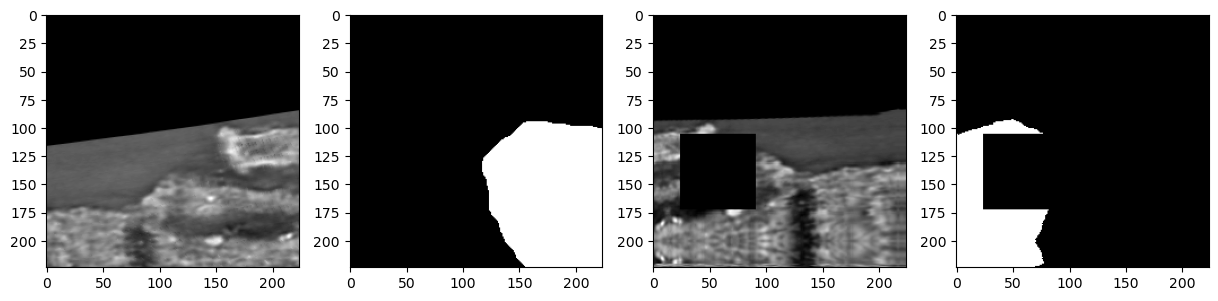

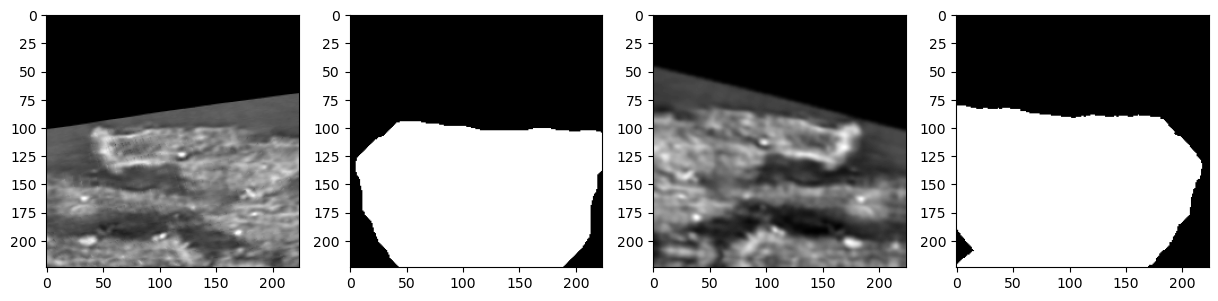

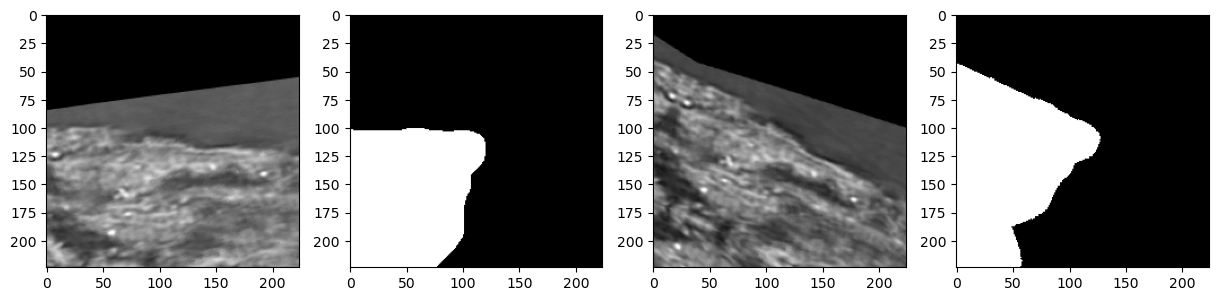

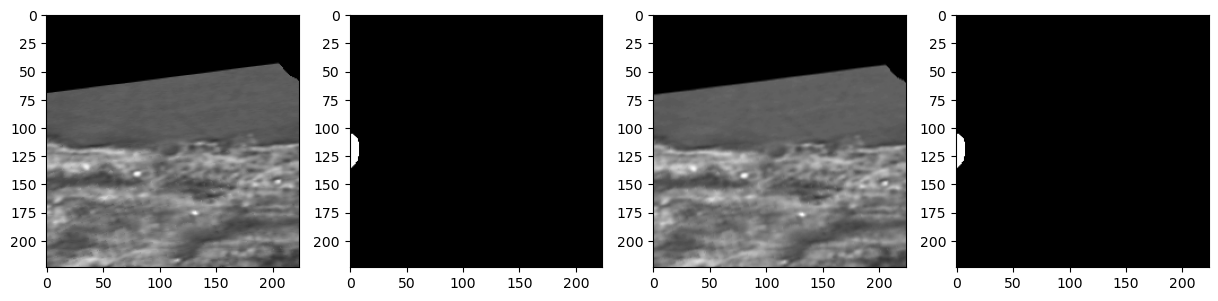

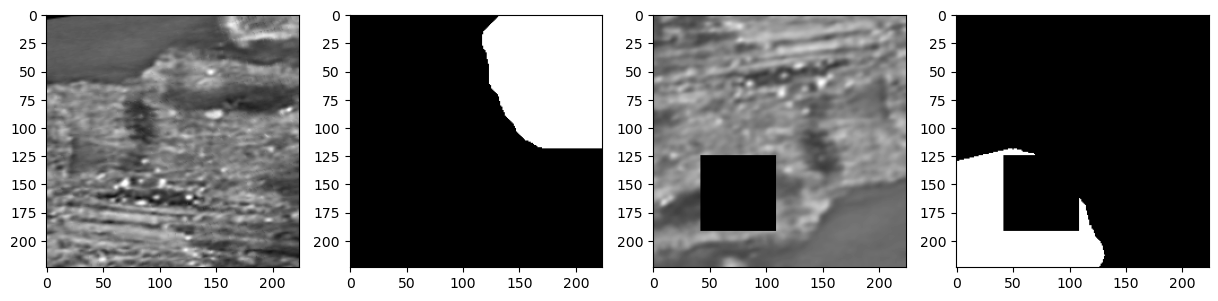

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48115

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext50_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.14208875124918674
th: 0.15, fbeta: 0.1420550459125035
th: 0.2, fbeta: 0.1418202643408875
th: 0.25, fbeta: 0.14153584710648853
th: 0.3, fbeta: 0.2092955550582242
th: 0.35, fbeta: 0.23476816283551724
th: 0.4, fbeta: 0.2498019611802667
th: 0.45, fbeta: 0.2536049588700052


best_th: 0.45, fbeta: 0.2536049588700052
Epoch 1 - avg_train_loss: 0.6397  avg_val_loss: 0.4766  time: 111s
Epoch 1 - avgScore: 0.2536
Epoch 1 - Save Best Score: 0.2536 Model
Epoch 1 - Save Best Loss: 0.4766 Model


th: 0.5, fbeta: 0.23118851071465854


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.14209266734328915
th: 0.15, fbeta: 0.1420917256945171
th: 0.2, fbeta: 0.19140139124123318
th: 0.25, fbeta: 0.22625102110954112
th: 0.3, fbeta: 0.2829236446661077
th: 0.35, fbeta: 0.28515848729480076
th: 0.4, fbeta: 0.23235918507309117
th: 0.45, fbeta: 0.1644340914342586


best_th: 0.35, fbeta: 0.28515848729480076
Epoch 2 - avg_train_loss: 0.4230  avg_val_loss: 0.3982  time: 112s
Epoch 2 - avgScore: 0.2852
Epoch 2 - Save Best Score: 0.2852 Model
Epoch 2 - Save Best Loss: 0.3982 Model


th: 0.5, fbeta: 0.10541265122173599


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.33804866459977106
th: 0.15, fbeta: 0.3307937670938842
th: 0.2, fbeta: 0.28880520318474234
th: 0.25, fbeta: 0.23960967405675093
th: 0.3, fbeta: 0.1845722508096646
th: 0.35, fbeta: 0.13328362754243114
th: 0.4, fbeta: 0.09408960055422402
th: 0.45, fbeta: 0.06522147007456104


best_th: 0.1, fbeta: 0.33804866459977106
Epoch 3 - avg_train_loss: 0.2678  avg_val_loss: 0.3409  time: 111s
Epoch 3 - avgScore: 0.3380
Epoch 3 - Save Best Score: 0.3380 Model
Epoch 3 - Save Best Loss: 0.3409 Model


th: 0.5, fbeta: 0.04154154968643608


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3790961688927409
th: 0.15, fbeta: 0.3214517142995519
th: 0.2, fbeta: 0.2518993065073495
th: 0.25, fbeta: 0.19515171776197723
th: 0.3, fbeta: 0.15096519873995157
th: 0.35, fbeta: 0.1157905094886565
th: 0.4, fbeta: 0.08965367925635591
th: 0.45, fbeta: 0.06997297618535767


best_th: 0.1, fbeta: 0.3790961688927409
Epoch 4 - avg_train_loss: 0.1973  avg_val_loss: 0.3751  time: 112s
Epoch 4 - avgScore: 0.3791
Epoch 4 - Save Best Score: 0.3791 Model
Epoch 4 - Save Best Loss: 0.3751 Model


th: 0.5, fbeta: 0.05306086781244037


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38111924674645553
th: 0.15, fbeta: 0.30245654103515834
th: 0.2, fbeta: 0.17773769332682815
th: 0.25, fbeta: 0.1022103793290362
th: 0.3, fbeta: 0.06275209535317772
th: 0.35, fbeta: 0.04105656147936025
th: 0.4, fbeta: 0.02775016781713711
th: 0.45, fbeta: 0.018805773216648884


best_th: 0.1, fbeta: 0.38111924674645553
Epoch 5 - avg_train_loss: 0.1834  avg_val_loss: 0.3773  time: 112s
Epoch 5 - avgScore: 0.3811
Epoch 5 - Save Best Score: 0.3811 Model
Epoch 5 - Save Best Loss: 0.3773 Model


th: 0.5, fbeta: 0.01273585388335809


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38904397525525397
th: 0.15, fbeta: 0.3715370968983981
th: 0.2, fbeta: 0.3441835492897273
th: 0.25, fbeta: 0.3054407320766555
th: 0.3, fbeta: 0.2654656590137012
th: 0.35, fbeta: 0.21776892022212715
th: 0.4, fbeta: 0.17198759883201198
th: 0.45, fbeta: 0.13201279301429292


best_th: 0.1, fbeta: 0.38904397525525397
Epoch 6 - avg_train_loss: 0.1704  avg_val_loss: 0.4024  time: 112s
Epoch 6 - avgScore: 0.3890
Epoch 6 - Save Best Score: 0.3890 Model
Epoch 6 - Save Best Loss: 0.4024 Model


th: 0.5, fbeta: 0.09610341606226522


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34517530759020526
th: 0.15, fbeta: 0.274265015272907
th: 0.2, fbeta: 0.21489996302543707
th: 0.25, fbeta: 0.16260757222726502
th: 0.3, fbeta: 0.12389754807714039
th: 0.35, fbeta: 0.09400235482349378
th: 0.4, fbeta: 0.07187812467514072
th: 0.45, fbeta: 0.055127463970168024


best_th: 0.1, fbeta: 0.34517530759020526
Epoch 7 - avg_train_loss: 0.1623  avg_val_loss: 0.4627  time: 112s
Epoch 7 - avgScore: 0.3452


th: 0.5, fbeta: 0.04136504178099539


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39006231767467775
th: 0.15, fbeta: 0.3656068506148038
th: 0.2, fbeta: 0.3274081159366544
th: 0.25, fbeta: 0.2817301440174472
th: 0.3, fbeta: 0.23512263149910767
th: 0.35, fbeta: 0.1890674237585443
th: 0.4, fbeta: 0.14939430197521822
th: 0.45, fbeta: 0.11755096677708723


best_th: 0.1, fbeta: 0.39006231767467775
Epoch 8 - avg_train_loss: 0.1517  avg_val_loss: 0.4316  time: 112s
Epoch 8 - avgScore: 0.3901
Epoch 8 - Save Best Score: 0.3901 Model
Epoch 8 - Save Best Loss: 0.4316 Model


th: 0.5, fbeta: 0.0922182476975332


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37091581574099375
th: 0.15, fbeta: 0.3351645042476704
th: 0.2, fbeta: 0.2977633923601582
th: 0.25, fbeta: 0.2637640288304165
th: 0.3, fbeta: 0.22983541901977625
th: 0.35, fbeta: 0.19383147031407005
th: 0.4, fbeta: 0.16193985775113032
th: 0.45, fbeta: 0.13192998133075542


best_th: 0.1, fbeta: 0.37091581574099375
Epoch 9 - avg_train_loss: 0.1432  avg_val_loss: 0.4569  time: 112s
Epoch 9 - avgScore: 0.3709


th: 0.5, fbeta: 0.10797212219019066


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.32543165379586586
th: 0.15, fbeta: 0.29117150828341565
th: 0.2, fbeta: 0.25158369957545385
th: 0.25, fbeta: 0.20890153541867001
th: 0.3, fbeta: 0.17195875906548932
th: 0.35, fbeta: 0.14219347949365024
th: 0.4, fbeta: 0.11418118601384528
th: 0.45, fbeta: 0.08838953924116284


best_th: 0.1, fbeta: 0.32543165379586586
Epoch 10 - avg_train_loss: 0.1328  avg_val_loss: 0.5092  time: 114s
Epoch 10 - avgScore: 0.3254


th: 0.5, fbeta: 0.06747559401532738


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37300635334828136
th: 0.15, fbeta: 0.36476822021763106
th: 0.2, fbeta: 0.34717376259515037
th: 0.25, fbeta: 0.3256663150567459
th: 0.3, fbeta: 0.30043261613206657
th: 0.35, fbeta: 0.26941918387122293
th: 0.4, fbeta: 0.23675990521691467
th: 0.45, fbeta: 0.20464255959835617


best_th: 0.1, fbeta: 0.37300635334828136
Epoch 11 - avg_train_loss: 0.1255  avg_val_loss: 0.4836  time: 112s
Epoch 11 - avgScore: 0.3730


th: 0.5, fbeta: 0.17126660304288843


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3739291828678207
th: 0.15, fbeta: 0.35819771327262667
th: 0.2, fbeta: 0.3309005818384946
th: 0.25, fbeta: 0.30100817611391506
th: 0.3, fbeta: 0.26847603413574467
th: 0.35, fbeta: 0.2370831207958588
th: 0.4, fbeta: 0.20610033108031794
th: 0.45, fbeta: 0.17747878000047898


best_th: 0.1, fbeta: 0.3739291828678207
Epoch 12 - avg_train_loss: 0.1173  avg_val_loss: 0.5450  time: 112s
Epoch 12 - avgScore: 0.3739


th: 0.5, fbeta: 0.15071960801052586


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.35274759015202545
th: 0.15, fbeta: 0.3647770310608933
th: 0.2, fbeta: 0.3722742014456132
th: 0.25, fbeta: 0.3761485060768706
th: 0.3, fbeta: 0.37671185359049253
th: 0.35, fbeta: 0.37419657468091705
th: 0.4, fbeta: 0.36767643469723144
th: 0.45, fbeta: 0.3585255632546123


best_th: 0.3, fbeta: 0.37671185359049253
Epoch 13 - avg_train_loss: 0.1110  avg_val_loss: 0.4645  time: 112s
Epoch 13 - avgScore: 0.3767


th: 0.5, fbeta: 0.34509958707123495


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.36088944880444074
th: 0.15, fbeta: 0.36311001742001187
th: 0.2, fbeta: 0.3612705444354975
th: 0.25, fbeta: 0.35408681215361276
th: 0.3, fbeta: 0.3404363005539814
th: 0.35, fbeta: 0.324192876272614
th: 0.4, fbeta: 0.3046395577496403
th: 0.45, fbeta: 0.281889179738967


best_th: 0.15, fbeta: 0.36311001742001187
Epoch 14 - avg_train_loss: 0.1064  avg_val_loss: 0.5497  time: 112s
Epoch 14 - avgScore: 0.3631


th: 0.5, fbeta: 0.25746087430277176


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34048667222951107
th: 0.15, fbeta: 0.3219063370596351
th: 0.2, fbeta: 0.3006437488603243
th: 0.25, fbeta: 0.2743886137378452
th: 0.3, fbeta: 0.246234245207271
th: 0.35, fbeta: 0.21849730923990177
th: 0.4, fbeta: 0.19110541014419025
th: 0.45, fbeta: 0.16377057322499394


best_th: 0.1, fbeta: 0.34048667222951107
Epoch 15 - avg_train_loss: 0.0978  avg_val_loss: 0.6011  time: 112s
Epoch 15 - avgScore: 0.3405


th: 0.5, fbeta: 0.13840502950197073


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.38399318967407964
th: 0.15, fbeta: 0.3880014159140378
th: 0.2, fbeta: 0.38842347566166036
th: 0.25, fbeta: 0.38406106203344265
th: 0.3, fbeta: 0.3740504204831672
th: 0.35, fbeta: 0.36451148395241695
th: 0.4, fbeta: 0.3519621731404055
th: 0.45, fbeta: 0.3350537179149215


best_th: 0.2, fbeta: 0.38842347566166036
Epoch 16 - avg_train_loss: 0.0928  avg_val_loss: 0.5673  time: 112s
Epoch 16 - avgScore: 0.3884


th: 0.5, fbeta: 0.31539285834765823


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3546423450504207
th: 0.15, fbeta: 0.33983097435212994
th: 0.2, fbeta: 0.31886414690840414
th: 0.25, fbeta: 0.29405332241862214
th: 0.3, fbeta: 0.26642763091184263
th: 0.35, fbeta: 0.2362354110332387
th: 0.4, fbeta: 0.20521528493875857
th: 0.45, fbeta: 0.178733604608423


best_th: 0.1, fbeta: 0.3546423450504207
Epoch 17 - avg_train_loss: 0.0884  avg_val_loss: 0.6122  time: 113s
Epoch 17 - avgScore: 0.3546


th: 0.5, fbeta: 0.15224057807187358


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3338676654725992
th: 0.15, fbeta: 0.3213218199302272
th: 0.2, fbeta: 0.3032047233568502
th: 0.25, fbeta: 0.28021590154941245
th: 0.3, fbeta: 0.2577434575417923
th: 0.35, fbeta: 0.23579323712091763
th: 0.4, fbeta: 0.20976264056226684
th: 0.45, fbeta: 0.18321369052287723


best_th: 0.1, fbeta: 0.3338676654725992
Epoch 18 - avg_train_loss: 0.0852  avg_val_loss: 0.6924  time: 112s
Epoch 18 - avgScore: 0.3339


th: 0.5, fbeta: 0.15619111843052472


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3274503520870737
th: 0.15, fbeta: 0.30954182390903673
th: 0.2, fbeta: 0.29167680721317046
th: 0.25, fbeta: 0.269314215598393
th: 0.3, fbeta: 0.24510084781731806
th: 0.35, fbeta: 0.21808657451449728
th: 0.4, fbeta: 0.19053833376815746
th: 0.45, fbeta: 0.16352713161176058


best_th: 0.1, fbeta: 0.3274503520870737
Epoch 19 - avg_train_loss: 0.0786  avg_val_loss: 0.6401  time: 112s
Epoch 19 - avgScore: 0.3275


th: 0.5, fbeta: 0.14103391534660242


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34406472935163385
th: 0.15, fbeta: 0.3189468438693325
th: 0.2, fbeta: 0.29102759477577417
th: 0.25, fbeta: 0.26361413582972637
th: 0.3, fbeta: 0.23515455905624966
th: 0.35, fbeta: 0.20876371472983904
th: 0.4, fbeta: 0.18326928842037474
th: 0.45, fbeta: 0.1571782368343358


best_th: 0.1, fbeta: 0.34406472935163385
Epoch 20 - avg_train_loss: 0.0761  avg_val_loss: 0.6940  time: 113s
Epoch 20 - avgScore: 0.3441


th: 0.5, fbeta: 0.13184185724119804


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3125033738499068
th: 0.15, fbeta: 0.2990190311325029
th: 0.2, fbeta: 0.28145814092890886
th: 0.25, fbeta: 0.2616088939366527
th: 0.3, fbeta: 0.2408423036844402
th: 0.35, fbeta: 0.21918758885005185
th: 0.4, fbeta: 0.19653944193083378
th: 0.45, fbeta: 0.17451191474491842


best_th: 0.1, fbeta: 0.3125033738499068
Epoch 21 - avg_train_loss: 0.0722  avg_val_loss: 0.7315  time: 112s
Epoch 21 - avgScore: 0.3125


th: 0.5, fbeta: 0.15178975962833618


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2510049012849688
th: 0.15, fbeta: 0.2219382288444472
th: 0.2, fbeta: 0.19257838748791092
th: 0.25, fbeta: 0.1660499051256953
th: 0.3, fbeta: 0.14358922932426507
th: 0.35, fbeta: 0.1254462334183324
th: 0.4, fbeta: 0.10879996693008644
th: 0.45, fbeta: 0.09327389610137464


best_th: 0.1, fbeta: 0.2510049012849688
Epoch 22 - avg_train_loss: 0.0687  avg_val_loss: 0.7703  time: 112s
Epoch 22 - avgScore: 0.2510


th: 0.5, fbeta: 0.07459554138969658


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3341888789282441
th: 0.15, fbeta: 0.32412364058469906
th: 0.2, fbeta: 0.30733427635473015
th: 0.25, fbeta: 0.28713758695448943
th: 0.3, fbeta: 0.2623727941270489
th: 0.35, fbeta: 0.23870461928443407
th: 0.4, fbeta: 0.21344791736783042
th: 0.45, fbeta: 0.187211092190806


best_th: 0.1, fbeta: 0.3341888789282441
Epoch 23 - avg_train_loss: 0.0657  avg_val_loss: 0.7209  time: 113s
Epoch 23 - avgScore: 0.3342


th: 0.5, fbeta: 0.15930289011327184


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3350901998582239
th: 0.15, fbeta: 0.3150639186435121
th: 0.2, fbeta: 0.28969552493910633
th: 0.25, fbeta: 0.26104966518702016
th: 0.3, fbeta: 0.23097884735623384
th: 0.35, fbeta: 0.19899013878599345
th: 0.4, fbeta: 0.16856095073278024
th: 0.45, fbeta: 0.14348291848263647


best_th: 0.1, fbeta: 0.3350901998582239
Epoch 24 - avg_train_loss: 0.0634  avg_val_loss: 0.7173  time: 112s
Epoch 24 - avgScore: 0.3351


th: 0.5, fbeta: 0.12150134182346192


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3340999941429332
th: 0.15, fbeta: 0.3191480440155381
th: 0.2, fbeta: 0.3006425701695345
th: 0.25, fbeta: 0.2786390371610572
th: 0.3, fbeta: 0.2551058665428548
th: 0.35, fbeta: 0.2309621048278511
th: 0.4, fbeta: 0.2047354891329653
th: 0.45, fbeta: 0.17761714399621337


best_th: 0.1, fbeta: 0.3340999941429332
Epoch 25 - avg_train_loss: 0.0613  avg_val_loss: 0.7572  time: 113s
Epoch 25 - avgScore: 0.3341


th: 0.5, fbeta: 0.15141123780982557


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.31437797258775496
th: 0.15, fbeta: 0.29524018417273146
th: 0.2, fbeta: 0.2728864747106581
th: 0.25, fbeta: 0.24772078279670945
th: 0.3, fbeta: 0.2221933264444318
th: 0.35, fbeta: 0.19787014478264922
th: 0.4, fbeta: 0.17461050563404076
th: 0.45, fbeta: 0.15185862652296395


best_th: 0.1, fbeta: 0.31437797258775496
Epoch 26 - avg_train_loss: 0.0600  avg_val_loss: 0.8098  time: 112s
Epoch 26 - avgScore: 0.3144


th: 0.5, fbeta: 0.12522338101992891


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3041485689328955
th: 0.15, fbeta: 0.2781179411593445
th: 0.2, fbeta: 0.2502621980476319
th: 0.25, fbeta: 0.22142139975488942
th: 0.3, fbeta: 0.19287995150199042
th: 0.35, fbeta: 0.16916074238717596
th: 0.4, fbeta: 0.1468033076344604
th: 0.45, fbeta: 0.12473720681501707


best_th: 0.1, fbeta: 0.3041485689328955
Epoch 27 - avg_train_loss: 0.0568  avg_val_loss: 0.8040  time: 112s
Epoch 27 - avgScore: 0.3041


th: 0.5, fbeta: 0.1011578207730866


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.332805851289063
th: 0.15, fbeta: 0.3110131890710889
th: 0.2, fbeta: 0.2844780747890226
th: 0.25, fbeta: 0.255837974907432
th: 0.3, fbeta: 0.22936764033324453
th: 0.35, fbeta: 0.2019030393310848
th: 0.4, fbeta: 0.17734982444172076
th: 0.45, fbeta: 0.15510503733914954


best_th: 0.1, fbeta: 0.332805851289063
Epoch 28 - avg_train_loss: 0.0571  avg_val_loss: 0.7835  time: 112s
Epoch 28 - avgScore: 0.3328


th: 0.5, fbeta: 0.13148245085855148


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3158498157720912
th: 0.15, fbeta: 0.29781541282598606
th: 0.2, fbeta: 0.2726409070250488
th: 0.25, fbeta: 0.24560894478920367
th: 0.3, fbeta: 0.219466409702965
th: 0.35, fbeta: 0.19426696828290063
th: 0.4, fbeta: 0.17039469497758183
th: 0.45, fbeta: 0.14927493165212727


best_th: 0.1, fbeta: 0.3158498157720912
Epoch 29 - avg_train_loss: 0.0552  avg_val_loss: 0.7787  time: 112s
Epoch 29 - avgScore: 0.3158


th: 0.5, fbeta: 0.12712710418770082


  0%|          | 0/456 [00:00<?, ?it/s]

  0%|          | 0/354 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3113185725023952
th: 0.15, fbeta: 0.287087789208861
th: 0.2, fbeta: 0.2591099818287582
th: 0.25, fbeta: 0.22814014252518613
th: 0.3, fbeta: 0.19859065884677882
th: 0.35, fbeta: 0.17541403585860774
th: 0.4, fbeta: 0.15440778132872562
th: 0.45, fbeta: 0.1336549519539599


best_th: 0.1, fbeta: 0.3113185725023952
Epoch 30 - avg_train_loss: 0.0553  avg_val_loss: 0.8122  time: 112s
Epoch 30 - avgScore: 0.3113


th: 0.5, fbeta: 0.11018452359404723


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.39006231767467775
th: 0.15, fbeta: 0.3656068506148038
th: 0.2, fbeta: 0.3274081159366544
th: 0.25, fbeta: 0.2817301440174472
th: 0.3, fbeta: 0.23512263149910767
th: 0.35, fbeta: 0.1890674237585443
th: 0.4, fbeta: 0.14939430197521822
th: 0.45, fbeta: 0.11755096677708723


best_th: 0.1, fbeta: 0.39006231767467775


th: 0.5, fbeta: 0.0922182476975332


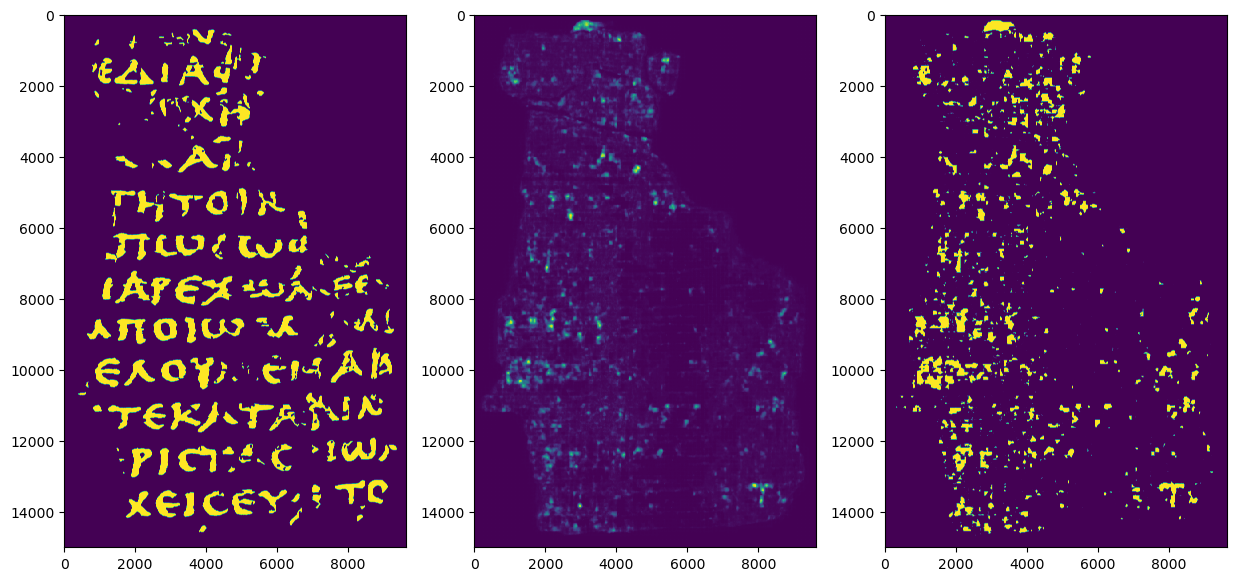

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([1.26908149e+08, 9.48791400e+06, 2.88071700e+06, 1.54920100e+06,
        1.06027500e+06, 7.01643000e+05, 5.08639000e+05, 3.73624000e+05,
        2.66604000e+05, 1.91604000e+05, 1.46205000e+05, 1.23410000e+05,
        9.59430000e+04, 7.53660000e+04, 5.62600000e+04, 4.17530000e+04,
        3.28920000e+04, 3.03500000e+04, 1.88670000e+04, 7.64000000e+03]),
 array([8.95085468e-05, 4.72222988e-02, 9.43550890e-02, 1.41487879e-01,
        1.88620669e-01, 2.35753460e-01, 2.82886250e-01, 3.30019040e-01,
        3.77151830e-01, 4.24284621e-01, 4.71417411e-01, 5.18550201e-01,
        5.65682991e-01, 6.12815781e-01, 6.59948572e-01, 7.07081362e-01,
        7.54214152e-01, 8.01346942e-01, 8.48479733e-01, 8.95612523e-01,
        9.42745313e-01]),
 <BarContainer object of 20 artists>)

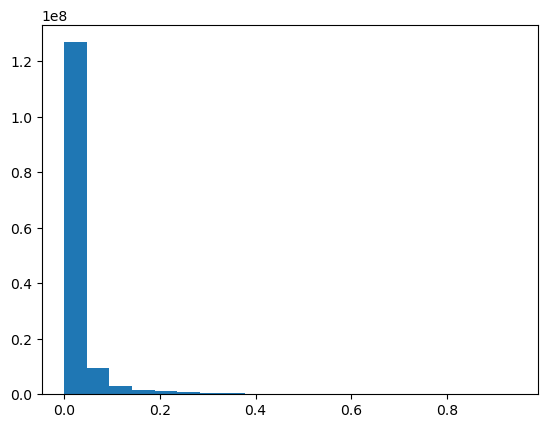

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000